# Measuring Communication Efficiency and Learnability of Colors using an Information Bottleneck Framework

In [1]:
import pandas as pd
import numpy as np
from ibhelpers import *

In [2]:
# load the data from the World Color Survey
df = pd.read_csv("wcs/term.txt", delimiter="\t", header=None)
df.columns = ["language", "speaker", "chip", "word"]

## Calculate prior probabilities

For each language, $l$, we can use a frequentist approach (counts) to calculate the observed quantities of $p(w|c,l)$ and $p(c|w,l)$

In [3]:
per_chip_count_df = df.groupby(["language", "chip", "word"]).speaker.agg(individual_count_per_word_per_chip="count")
total_word_count_df = df.groupby(["language", "chip"]).word.agg(total_words_per_chip="count")

# frequentist probability of a word given chip and language
p_word_chip_language = per_chip_count_df["individual_count_per_word_per_chip"] / total_word_count_df["total_words_per_chip"]
p_word_chip_language.head(5)

language  chip  word
1         1     F       0.08
                G       0.52
                LB      0.36
                LF      0.04
          2     F       0.60
dtype: float64

In [4]:
per_word_count_df = df.groupby(["language", "word", "chip"]).speaker.agg(individual_count_per_chip_per_word="count")
total_chip_count_df = df.groupby(["language", "word"]).chip.agg(total_chips_per_word="count")

# frequentist probability of a chip given word and language
p_chip_word_language = per_word_count_df["individual_count_per_chip_per_word"] / total_chip_count_df["total_chips_per_word"]
p_chip_word_language.head(5)

language  word  chip
1         F     1       0.001366
                2       0.010246
                4       0.001366
                5       0.011612
                6       0.003415
dtype: float64

## Information Bottleneck

Code taken from Frank (osfstorage)

### Initialise components for optimising IB objective

We need to initialise a joint prior distribution of words and meanings, i.e. `p_wm`, and a corresponding variational joint distribution, i.e. `q0` (q_wm_0).

In [5]:
# number of possible meanings
n_meanings = 330 #@TODO: change this with the correct number from WCS
n_words = n_meanings

# to avoid underflow problem
eps = 0.0001

q0 = (1 - eps) * np.eye(n_meanings) + eps * np.ones((n_meanings, n_meanings))

# p_x = p(m)
# to find p(m) - find the most common word for each chip and assign chip to that word\n

language = 1

#Find the most common word for each chip and assign chip to that word\n
p_word_chip_language[1].groupby(level=0).idxmax()

# convert words to indices
words = p_chip_word_language[1].reset_index().word.unique()
word_to_index =  {word: i for word, i in zip(words, range(len(words))) }
index_to_word =  {i: word for word, i in zip(words, range(len(words))) }

# assigne a word to each chip
chip_to_word = np.zeros(n_meanings)
for chip_num, word in p_word_chip_language[1].groupby(level=0).idxmax().values:
    chip_to_word[chip_num-1] = word_to_index[word]

# Find the frequency of that color in data, then split it equally across all the chips assigned to it\n
word_frequencies = p_chip_word_language[1].reset_index().word.apply(lambda x: word_to_index[x]).value_counts()

p_x = np.zeros(n_meanings)
for i in range(n_meanings):
    p_x[i] = 1 / word_frequencies[chip_to_word[i]]

Calculate $p(x|y)$ (p_xGy) using a PDF over chips in lab space

In [6]:
from scipy.stats import norm, multivariate_normal
from scipy.special import softmax

p_xGy = np.zeros((n_meanings, n_meanings))

chip2lab = pd.read_csv("wcs/cnum-vhcm-lab-new.txt", sep="\t", header=0, index_col="#cnum")
chip2lab = chip2lab.sort_values(by="#cnum")[["L*", "a*", "b*"]].copy().reset_index()


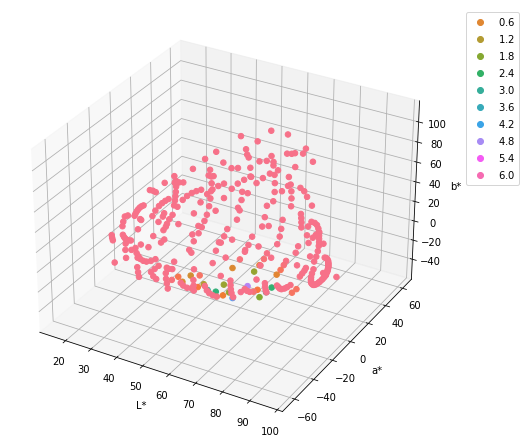

In [7]:
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

labspace = chip2lab[["L*", "a*", "b*"]].values
COVARIANCE = 100 # @TODO: This is a hyperparameter than needs to be justified

for i in range(n_meanings):
    # the multivariate pdf over the lab space dimension to go back into chip/meaning space 
    p_xGy[i] = multivariate_normal.pdf(labspace, mean=labspace[i], cov=COVARIANCE)

# generate data
n = 200
x = labspace[:,0]
y = labspace[:,1]
z = labspace[:,2]

# We will plot the pdf for the first chip in Lab space
# to check that some probability is being assigned to each surrounding chip
c = p_xGy[0]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=30, c=c, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('L*')
ax.set_ylabel('a*')
ax.set_zlabel('b*')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [8]:
# q0 = q0 / q0.sum(axis=1, keepdims=True) 
q0 = np.eye(330) # q0 initial encoder - can set it to identity

betas = np.array([2 ** x for x in np.arange(5, 0, -0.01)])
focalbeta = 1.0

# calculate p_xy from p_x and p_xGy
p_mGs = p_xGy / np.sum(p_xGy, axis=0)
p_xGy = p_xGy / p_xGy.sum(axis=1, keepdims=True)
p_xy = p_xGy * p_x[:, np.newaxis]
p_xy = p_xy / np.sum(p_xy)

In [9]:
q, beta, ibscores, qresult, qseq, qseqresults, allqs = fit_ib(p_xy, q0, focalbeta, betas, verbose=1)

items = [str(x+1) for x in range(n_meanings)]
columns = ['M'+str(i) for i in items]

# create data frames for plotting and analysis
ib_scores_df = pd.DataFrame(np.array(ibscores), columns = ['rate', 'distortion', 'elen'])
ib_scores_df['beta'] = betas
ib_scores_df['q'] = allqs
ib_scores_df['Wn'] = [mergecols(q).shape[1] for q in ib_scores_df['q']]

32.0:323
31.778959853985153:323
31.5594465437875:321
31.341449522781673:320
31.124958317193155:319
30.90996252559508:319
30.696451818408487:318
30.484415937406027:314
30.273844695219104:314
30.064727974848417:310
29.85705572917788:307
29.650817980491915:306
29.446004819996055:303
29.242606407340872:300
29.04061297014921:300
28.84001480354663:300
28.640802269695186:299
28.442965797330316:299
28.24649588130103:298
28.0513830821132:297
27.857618025476054:297
27.66519140185177:296
27.47409396600821:297
27.284316536574707:294
27.095849995600965:292
26.908685288118964:291
26.722813421707922:290
26.53822546606224:289
26.35491255256245:287
26.17286587384911:287
25.992076683399652:287
25.81253629510816:286
25.63423608286803:286
25.457167480157523:284
25.281321979628196:284
25.106691132696152:284
24.93326654913613:283
24.761039896678373:283
24.590002900608336:283
24.420147343369088:282
24.251465064166513:282
24.083947958577223:280
23.917587978159162:280
23.752377130064936:278
23.58830747665777:2

In [13]:
# The structural phase transitions along the pareto frontier
stochSys = []
for i, q in enumerate(zip(qseq, qseqresults)):
    for w in mergecols(q[0]).transpose():
        stochSys.append([len(qseq)-i, q[1][0], q[1][1]] + list(w))

stochSys = pd.DataFrame(data=np.array(stochSys), columns = ['n', 'rate', 'distortion'] + columns)

In [14]:
stochSys 

,n,rate,distortion,M1,M2,M3,M4,M5,M6,M7,...,M321,M322,M323,M324,M325,M326,M327,M328,M329,M330
0,221.0,7.537290,0.009459,0.000000e+00,6.960017e-253,0.000000e+00,0.000000e+00,7.590536e-209,3.932940e-204,7.896667e-129,...,0.000000e+00,0.000000e+00,4.741960e-141,0.000000e+00,0.000000e+00,2.178866e-210,0.000000e+00,9.509205e-55,7.083614e-64,1.655164e-268
1,221.0,7.537290,0.009459,0.000000e+00,0.000000e+00,5.090878e-45,0.000000e+00,0.000000e+00,1.416856e-140,0.000000e+00,...,5.771885e-206,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.535450e-68,0.000000e+00,0.000000e+00,3.053509e-75,0.000000e+00
2,221.0,7.537290,0.009459,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.482859e-252,1.234651e-258,1.001625e-38,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.932203e-111,0.000000e+00,0.000000e+00,8.215823e-285,0.000000e+00
3,221.0,7.537290,0.009459,0.000000e+00,0.000000e+00,2.674522e-22,0.000000e+00,0.000000e+00,1.531235e-272,0.000000e+00,...,7.953983e-270,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.523745e-106,0.000000e+00,0.000000e+00,7.915015e-176,0.000000e+00
4,221.0,7.537290,0.009459,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.708878e-136,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.898152e-49,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35586,3.0,1.960452,2.260257,3.030281e-03,3.028149e-03,5.086788e-04,3.030075e-03,3.011432e-03,2.973040e-03,3.114496e-04,...,2.989735e-03,3.030190e-03,3.021566e-03,3.027160e-03,3.030216e-03,2.627973e-05,3.028029e-03,2.987902e-03,2.042460e-03,3.027271e-03
35587,2.0,1.109697,3.019291,6.489537e-07,8.959075e-07,2.268756e-03,7.499699e-06,7.144486e-06,4.351467e-05,1.755628e-03,...,1.047106e-04,5.498245e-07,3.463636e-05,6.338189e-07,3.663953e-06,2.947456e-03,4.519139e-07,2.112712e-04,1.671207e-03,5.064906e-07
35588,2.0,1.109697,3.019291,5.626748e-08,7.234924e-07,3.081497e-08,1.000398e-09,6.398477e-07,5.466898e-06,1.151040e-06,...,3.339221e-08,1.605455e-07,1.202248e-08,1.110608e-06,2.673035e-09,5.274426e-08,9.306165e-07,7.564868e-09,2.175813e-08,1.044834e-06
35589,2.0,1.109697,3.019291,3.029598e-03,3.028684e-03,7.615160e-04,3.022802e-03,3.022519e-03,2.981321e-03,1.273524e-03,...,2.925559e-03,3.029593e-03,2.995655e-03,3.028559e-03,3.026636e-03,8.279386e-05,3.028920e-03,2.819024e-03,1.359075e-03,3.028752e-03


<AxesSubplot:xlabel='rate'>

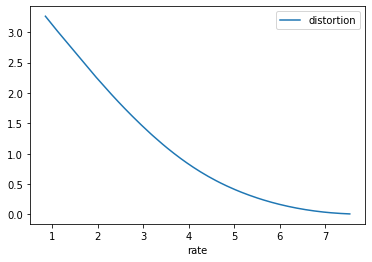

In [15]:
stochSys.cumsum()
stochSys.plot(x="rate", y='distortion')

<AxesSubplot:xlabel='rate', ylabel='distortion'>

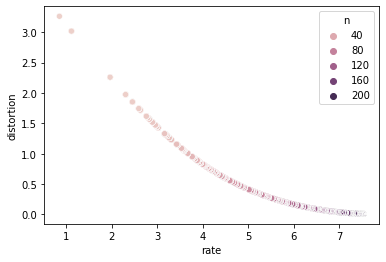

In [17]:
import seaborn as sns

sns.scatterplot(x="rate", y='distortion', hue="n", data=stochSys)

### The Pareto Frontier
Now let's run the Information Bottleneck Method

In [ ]:


# The structural phase transitions along the pareto frontier
stochSys = []
for i, q in enumerate(zip(qseq, qseqresults)):
    for w in mergecols(q[0]).transpose():
        stochSys.append([len(qseq)-i, q[1][0], q[1][1]] + list(w))

stochSys = pd.DataFrame(data=np.array(stochSys), columns = ['n', 'rate', 'distortion'] + items)


In [ ]:
from scipy.spatial import distance

# compute distance from optimal frontier
def fd(asys, ibscores):
    mind = distance.cdist([[asys['rate'], asys['distortion']]], ibscores[['rate', 'distortion']]).min()
    return mind


def gNID_d(asys, paretoQs, betas, pX):
    mind = np.zeros((len(asys), len(paretoQs)))
    for li in range(len(asys)):
        for qi, q in enumerate(paretoQs):
            mind[li, qi] = gNID(asys.iloc[li]['q'], q, pX)
    return np.argmin(mind, axis=1), np.min(mind, axis=1), betas[np.argmin(mind, axis=1)]

